In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

# Replace with your actual sample ID
sample_id = "IMMUNEX001"

# Paths
base_path = f"/scratch/IMMUNEX/OUTPUT/Visium_NSCLC_{sample_id}/outs/binned_outputs/square_002um"
h5_path = f"{base_path}/filtered_feature_bc_matrix.h5"
spatial_path = f"{base_path}/spatial/tissue_positions.parquet"

# Step 1: Load expression data
adata = sc.read_10x_h5(h5_path)

# Step 2: Load spatial coordinates
spatial = pd.read_parquet(spatial_path)
spatial.set_index("barcode", inplace=True)

# Step 3: Match spatial info to adata.obs
adata.obs = adata.obs.join(spatial, how="left")

# Step 4: Assign spatial coordinates
adata.obsm["spatial"] = adata.obs[["pxl_col_in_fullres", "pxl_row_in_fullres"]].to_numpy()


/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [2]:
print(adata)
print(adata.obs.head())
print(adata.obsm["spatial"][:5])


AnnData object with n_obs × n_vars = 10822530 × 18536
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
                       in_tissue  array_row  array_col  pxl_row_in_fullres  \
s_002um_00658_01498-1          1        658       1498        49072.541240   
s_002um_02587_02503-1          1       2587       2503        66022.627347   
s_002um_01674_00710-1          1       1674        710        57893.975667   
s_002um_02498_02808-1          1       2498       2808        65268.868357   
s_002um_00952_00136-1          1        952        136        51533.762147   

                       pxl_col_in_fullres  
s_002um_00658_01498-1        72584.407589  
s_002um_02587_02503-1        63950.896847  
s_002um_01674_00710-1        79557.093281  
s_002um_02498_02808-1        61276.597239  
s_002um_00952_00136-1        84518.653841  
[[72584.40758878 49072.54123991]
 [63950.89684709 66022

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

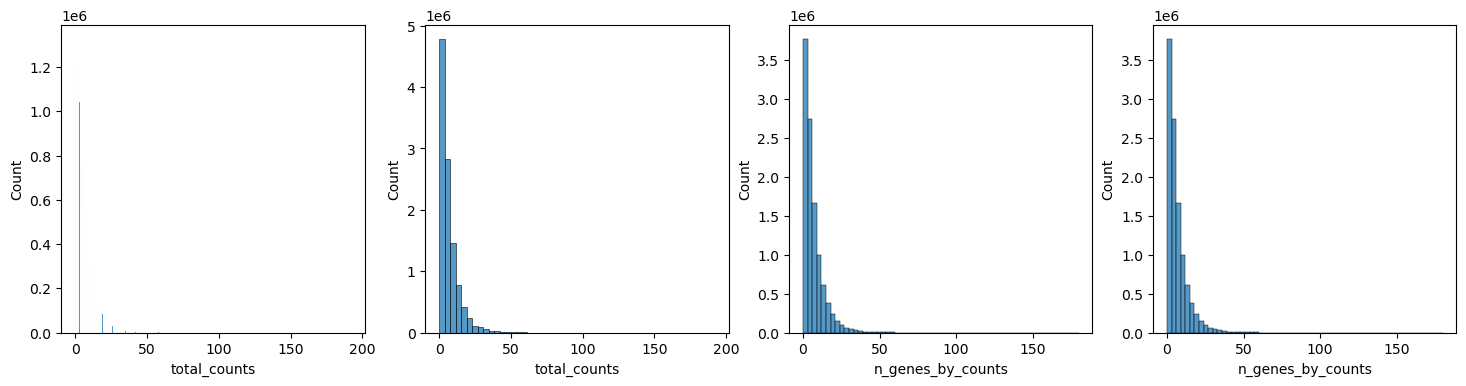

In [3]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
sns.histplot(adata.obs["total_counts"], ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 50000], bins=50, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], bins=60, ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 5000], bins=60, ax=axs[3])


In [4]:
sc.pp.filter_cells(adata, min_counts=5)
sc.pp.filter_cells(adata, max_counts=1000)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
sc.pp.filter_genes(adata, min_cells=10)
adata


/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4882194 × 17624
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

In [5]:
# sc.pp.normalize_total(adata, inplace=True)
# sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=500)
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 4882194 × 500
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'spatial'

/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


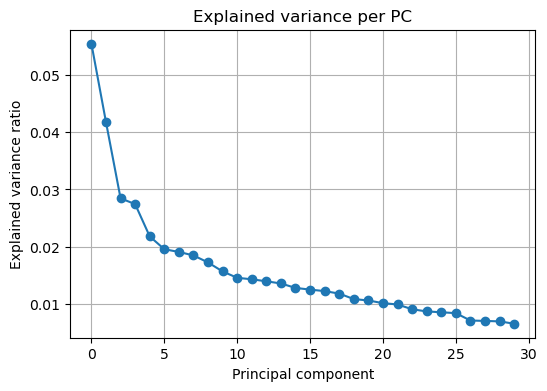

In [6]:
sc.pp.pca(adata, n_comps=30)

plt.figure(figsize=(6, 4))
plt.plot(adata.uns["pca"]["variance_ratio"][:50], marker="o")
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("Explained variance per PC")
plt.grid(True)
plt.show()


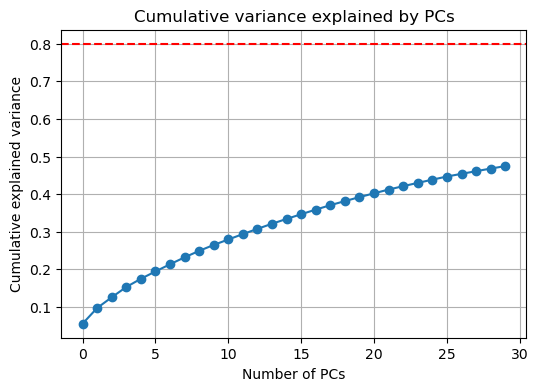

Recommended number of PCs: 1


In [7]:

plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(adata.uns["pca"]["variance_ratio"][:50]), marker="o")
plt.axhline(y=0.8, linestyle="--", color="red")  # 80% threshold
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative variance explained by PCs")
plt.grid(True)
plt.show()

n_pcs = np.argmax(np.cumsum(adata.uns["pca"]["variance_ratio"]) > 0.80) + 1
print(f"Recommended number of PCs: {n_pcs}")


In [8]:
import time
s = time.time()
sc.pp.neighbors(adata, n_neighbors = 15 , n_pcs=6)
print( (time.time() - s)  / 60)

2025-05-24 21:58:53.963927: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-24 21:58:53.965143: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 21:58:53.968312: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 21:58:53.976064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-24 21:58:53.993422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

12.562955033779144


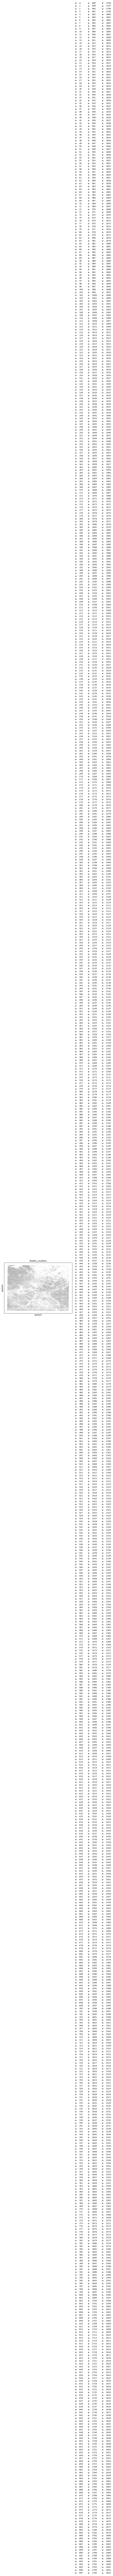

In [11]:
sc.tl.leiden(adata, key_added="leiden_clusters", resolution=0.00001)
sc.pl.embedding(adata, basis="spatial", color="leiden_clusters")

In [27]:
import squidpy as sq
sq.gr.spatial_neighbors(adata, coord_type="grid", n_neighs=6, key_added='spatial_clusters')
adata

AnnData object with n_obs × n_vars = 8974353 × 17792
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'spatial_neighbors', 'spatial_clusters_neighbors'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'spatial_connectivities', 'spatial_distances', 'spatial_clusters_connectivities', 'spatial_clusters_distances'

In [ ]:
sc.tl.leiden(adata, key_added="leiden_clusters", resolution=0.1)
adata

In [ ]:
sc.pl.embedding(
    adata,
    basis="spatial",
    color="leiden_clusters",
    size=5,
    alpha=0.5,
    img=False
)


In [ ]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"])
